<a href="https://colab.research.google.com/github/Existanze54/sirius-neural-networks-2024/blob/main/Homeworks/HW5_Graphs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание 5. Собираем свой GCN

Попробуйте улучшить метрику конволюциионной графовой сети с семинара.

In [ ]:
import torch

# Check pytorch version and make sure you use a GPU Kernel
!python -c "import torch; print(torch.__version__)"
!python -c "import torch; print(torch.version.cuda)"
!nvidia-smi

2.3.0+cu121
12.1
Thu May 23 12:26:49 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+--------

Следующий блок может считаться вплоть до 20 минут. Это среднее время самого обычного приключения с возвращением в исходную точку.

In [ ]:
%%bash
TORCH="1.10.0"
CUDA="cu111"
pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}+${CUDA}.html
pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}+${CUDA}.html
pip install torch-geometric

In [ ]:
!pip install decorator numpy matplotlib tqdm networkx ninja jinja2 rdkit-pypi

# Задание 1. Закрепляем материал с семинара

Будем использовать датасет eSOL - данные о растворимости органических веществ. Наша графовая нейронная сеть (GNN) будет предсказывать растворимость этих веществ. Тип задачи - задача бинарной классификации

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx


def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()


def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    plt.show()

In [ ]:
import rdkit
from torch_geometric.datasets import MoleculeNet

# Load the ESOL dataset
dataset = MoleculeNet(root=".", name="ESOL")
dataset

Processing...
Done!


ESOL(1128)

In [ ]:
print("Dataset type: ", type(data))
print("Dataset features: ", data.num_features)
print("Dataset targets: ", data.num_classes)
print("Dataset length: ", data.len)
print("Dataset sample: ", data[0])
print("Sample  nodes: ", data[0].num_nodes)
print("Sample  edges: ", data[0].num_edges)

Как было сказано на семинаре, num_classes посчитано неверно. На самом деле у нас два класса:

0 - нерастворимое вещество

1 - растворимое вещество

Поэтому будем на аутпут архитектуры подавать 1 значение - 0 или 1

In [ ]:
data = dataset[0]# Get the first graph object.

print(data)
print('==============================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])
Number of nodes: 34
Number of edges: 156
Average node degree: 4.59
Number of training nodes: 4
Training node label rate: 0.12
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [ ]:
data[4].edge_attr

tensor([[12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1]])

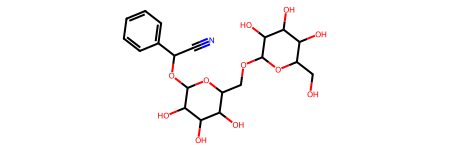

In [ ]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
molecule = Chem.MolFromSmiles(data[0]["smiles"])
molecule

Архитектура GNN

In [ ]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool, BatchNorm
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
embedding_size = 64

class GCN(torch.nn.Module):
    def __init__(self):
        # Init parent
        super(GCN, self).__init__()
        torch.manual_seed(42)

        # GCN layers
        self.initial_conv = GCNConv(data.num_features, embedding_size)
        self.conv1 = GCNConv(embedding_size, embedding_size)
        self.conv2 = GCNConv(embedding_size, embedding_size)
        self.conv3 = GCNConv(embedding_size, embedding_size)

        # Output layer
        self.out = Linear(embedding_size * 2, 1) # наше одно предсказанное число

    def forward(self, x, edge_index, batch_index):
        # First Conv layer
        hidden = self.initial_conv(x, edge_index)
        hidden = F.relu(hidden)

        # Other Conv layers
        hidden = self.conv1(hidden, edge_index)
        hidden = F.relu(hidden)
        hidden = self.conv2(hidden, edge_index)
        hidden = F.relu(hidden)
        hidden = self.conv3(hidden, edge_index)
        hidden = F.relu(hidden)

        # Global Pooling (stack different aggregations)
        hidden = torch.cat([gmp(hidden, batch_index),
                            gap(hidden, batch_index)], dim=1)

        # Apply a final (linear) classifier.
        out = self.out(hidden)

        return out, hidden

model = GCN()
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

GCN(
  (initial_conv): GCNConv(9, 64)
  (conv1): GCNConv(64, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (out): Linear(in_features=128, out_features=734, bias=True)
)
Number of parameters:  107806


Обучим нейросеть

In [ ]:
from torch_geometric.data import DataLoader
import warnings
warnings.filterwarnings("ignore")

# Root mean squared error
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Use GPU for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Wrap data in a data loader
data_size = len(data)
NUM_GRAPHS_PER_BATCH = 64
# train 80%, test 20%
loader = DataLoader(data[:int(data_size * 0.8)],
                    batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
test_loader = DataLoader(data[int(data_size * 0.8):],
                         batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)

def train(data):
    # Enumerate over the data
    for batch in loader:
      # Use GPU
      batch.to(device)
      # Reset gradients
      optimizer.zero_grad()
      # Passing the node features and the connection info
      pred, embedding = model(batch.x.float(), batch.edge_index, batch.batch)
      # Calculating the loss and gradients
      loss = torch.sqrt(loss_fn(pred, batch.y)) # RMSE
      loss.backward()
      # Update using the gradients
      optimizer.step()
    return loss, embedding

print("Starting training...")
losses = []
for epoch in range(2000):
    loss, h = train(data)
    losses.append(loss)
    if epoch % 100 == 0:
      print(f"Epoch {epoch} | Train Loss {loss}")

Starting training...
Epoch 0 | Train Loss 3.5835533142089844
Epoch 100 | Train Loss 0.5903552770614624
Epoch 200 | Train Loss 1.0117671489715576
Epoch 300 | Train Loss 0.6260981559753418
Epoch 400 | Train Loss 0.24686883389949799
Epoch 500 | Train Loss 0.29858919978141785
Epoch 600 | Train Loss 0.4440445303916931
Epoch 700 | Train Loss 0.18852819502353668
Epoch 800 | Train Loss 0.4074617326259613
Epoch 900 | Train Loss 0.3826480507850647
Epoch 1000 | Train Loss 0.6698839664459229
Epoch 1100 | Train Loss 0.1897260993719101
Epoch 1200 | Train Loss 0.6133278012275696
Epoch 1300 | Train Loss 0.5121704339981079
Epoch 1400 | Train Loss 0.17889836430549622
Epoch 1500 | Train Loss 0.35869139432907104
Epoch 1600 | Train Loss 0.44999125599861145
Epoch 1700 | Train Loss 0.22185508906841278
Epoch 1800 | Train Loss 0.35271307826042175
Epoch 1900 | Train Loss 0.3452291786670685


Визуализируем лосс

<Axes: >

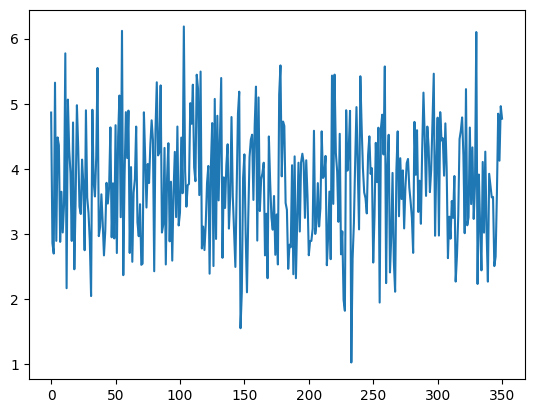

In [ ]:
import seaborn as sns

losses_float = [float(loss.cpu().detach().numpy()) for loss in losses]
loss_indices = [i for i,l in enumerate(losses_float)]
# plt = sns.lineplot(loss_indices, losses_float)
plt = sns.lineplot(losses_float)
plt

Проанализируем результаты для одного батча

<Axes: xlabel='y_real', ylabel='y_pred'>

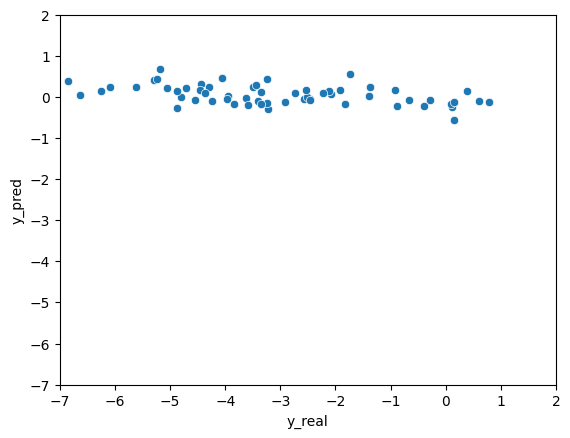

In [ ]:
import pandas as pd

# прогоним один раз
test_batch = next(iter(test_loader))
with torch.no_grad():
    test_batch.to(device)
    pred, embed = model(test_batch.x.float(), test_batch.edge_index, test_batch.batch)
    df = pd.DataFrame()
    df["y_real"] = test_batch.y.tolist()
    df["y_pred"] = pred.tolist()
df["y_real"] = df["y_real"].apply(lambda row: row[0])
df["y_pred"] = df["y_pred"].apply(lambda row: row[0])

plt = sns.scatterplot(data=df, x="y_real", y="y_pred")
plt.set(xlim=(-7, 2))
plt.set(ylim=(-7, 2))
plt

In [ ]:
metrics = nn.MSE

По одной оси реальные y, по другой предсказания нейросети. Если предсказанные y идеально соответствуют реальным, то на графике должна быть одна диагональная линия без каких-либо выбросов в стороны

# Задание 2. Создаем свою графовую сеть
Как и в предыдущих дз, попробуйте создать свою архитектуру, которая побьет метрики с семинара. Можно измменять любые параметры (включая лосс функцию). Переверните там все вверх дном, но найдите, найдите эту архитектуру. Это метрики, которые не достойны падать!

In [ ]:
# your code here